
# CMB Modular Pipeline — End‑to‑End Demo

This notebook shows two ways to use the pipeline:
- **Step‑by‑step**: call each primitive (load → HPF → video → slices → model → back‑project → viz).
- **High‑level**: call the convenience wrappers (`detect_on_slices`, `demo_gallery`), then export results.

> **Prereq:** The file `cmb_modular_pipeline.py` should be in the same folder as this notebook (or on `sys.path`).


## 0. Setup

In [1]:
# - Ensure 'cmb_modular_pipeline.py' is reachable (same folder or on sys.path).
import os, sys, math, json

import numpy as np
import matplotlib.pyplot as plt

# Make sure the module is importable
if not os.path.exists("cmb_modular_pipeline.py"):
    print("Couldn't find 'cmb_modular_pipeline.py' in this folder. "
          "Place it next to this notebook or add its directory to sys.path.")

from cmb_modular_pipeline import (
    # contexts & IO
    load_tod_ctx, build_fplane, tod_to_video,
    # processing
    pct_clip_norm, slices_to_images, highpass_rows,
    # inference & mapping
    TinyUNet, run_model, preds_to_det_hits, detect_on_slices,
    # data structures
    TodContext, FpContext, SliceResult,
    # viz helpers
    plot_filtered_images, plot_prob_maps, plot_composite, plot_timestreams,
    # export
    results_to_dataframe,
    # plot_class_scatter_fp,
    plot_class_scatter_hits,
    per_slice_det_probs,
    demo_gallery

)


# --- Config (edit these) ---
DEPOT_PATH  = "/home/yilun/shared/depots/yilun/"
RELEASE_TAG = "20230220"
BAND        = "f090"
S_RATE_HZ   = 400.0

# Example TOD and slices
tod_id = "1575860019.1575871071.ar5:f090"
# tod_id = "1559721031.1559730941.ar5:f090"
slices = [(127152,127822), (1510,1951), (134353,135001), (21394,21936), (24965,25906)]
# slices = [(206867,207272)]

# Model checkpoint
# CKPT_PATH = "/home/theanas12/anasProjects/cmb_Unet_run1/models/checkpoints_multilabel_finetuned/unet_multilabel_ep120_best.pt"
CKPT_PATH = "/home/theanas12/anasProjects/cmb_Unet_run1/models/checkpoints_multilabel/unet_multilabel_ep35_best.pt"


# Thresholds
thr = {"CR":0.5, "PS":0.5, "EL":0.5}

print("Config ok.")


Config ok.


In [2]:
# /home/theanas12/anasProjects/cmb_Unet_run1/data/real_converted_images32/images/cosmic_ray/TOD_1559721688.1559730981.ar5:f090_converted_123932-124338.png
# /home/theanas12/anasProjects/cmb_Unet_run1/data/real_converted_images32/images/cosmic_ray/TOD_1559721688.1559730981.ar5:f090_converted_2193-2515.png
# /home/theanas12/anasProjects/cmb_Unet_run1/data/real_converted_images32/images/cosmic_ray/TOD_1559635521.1559644468.ar5:f090_converted_0-293.png
# TOD_1567419530.1567428401.ar5:f090_converted_78579-79242


## 1. Load model (TinyUNet) and checkpoint

In [3]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyUNet(n_classes=3).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])   # key set by your saver
model.eval()
print("✅ checkpoint loaded:", os.path.basename(CKPT_PATH), "epoch", ckpt.get("epoch","?") )


✅ checkpoint loaded: unet_multilabel_ep35_best.pt epoch 35


## 2. Load TOD once; build focal-plane once

In [4]:
ctx = load_tod_ctx(tod_id, depot=DEPOT_PATH, release=RELEASE_TAG, band=BAND, s_rate_hz=S_RATE_HZ)
fp  = build_fplane(ctx, grid_res=32)

print("TOD:", ctx.tod_id, "| band:", ctx.band, "| release:", ctx.release)
print("Detectors:", ctx.det_uids.size, "Samples:", ctx.data.shape[1], "srate:", ctx.s_rate_hz)


tod loaded
Loaded tags from /home/yilun/shared/depots/yilun/release_20230220/release.txt
-> cuts loaded in tod.cuts tagged: pa5_f090_s19
-> partial cuts loaded in tod.partial tagged: pa5_f090_s19_partial
-> cal loaded in tod.cal tagged: pa5_f090_s19
step: ff_mce
step: cal
step: demean
step: detrend
TOD: 1575860019.1575871071.ar5:f090 | band: f090 | release: 20230220
Detectors: 709 Samples: 228851 srate: 400.0


### 2a. Triangulation & valid grid

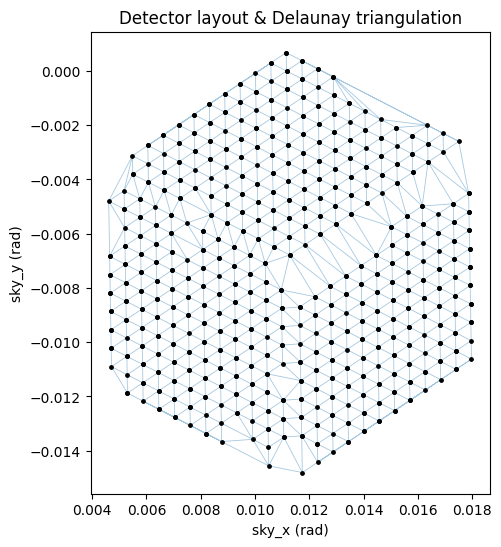

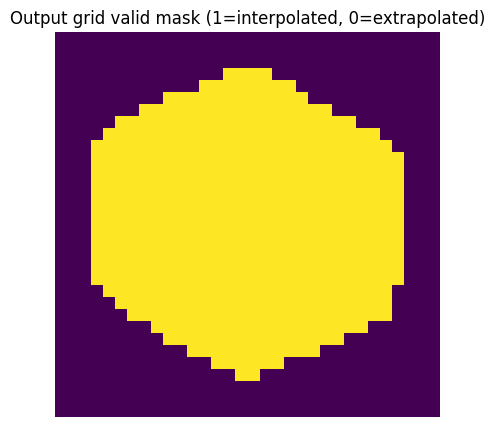

In [5]:
%matplotlib inline
coords = fp.flex.detector_coords
tris   = fp.flex.triangulation.simplices
valid  = fp.flex.valid_mask.reshape(fp.flex.grid_shape)

plt.figure(figsize=(6,6))
plt.triplot(coords[:,0], coords[:,1], tris, lw=0.6, alpha=0.4)
plt.scatter(coords[:,0], coords[:,1], s=6, c="k")
plt.title("Detector layout & Delaunay triangulation")
plt.xlabel("sky_x (rad)"); plt.ylabel("sky_y (rad)")
plt.gca().set_aspect("equal"); plt.show()

plt.figure(figsize=(5,5))
plt.imshow(valid.astype(int), origin="upper")
plt.title("Output grid valid mask (1=interpolated, 0=extrapolated)")
plt.axis("off"); plt.show()


## 3. TOD → HPF → video (cached)

Video cube: (228851, 32, 32)


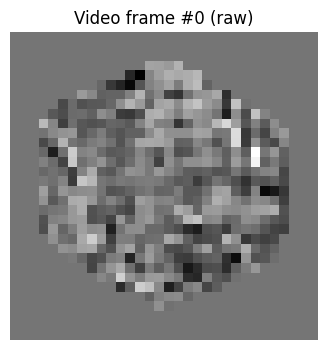

In [6]:
video = tod_to_video(ctx, fp, hp_filter=(2.0, 5), use_cache=True)  # (T,H,W)
print("Video cube:", video.shape)

plt.figure(figsize=(4,4))
plt.imshow(video[0], cmap="gray")
plt.title("Video frame #0 (raw)")
plt.axis("off"); plt.show()


## 4. Slice reductions → images

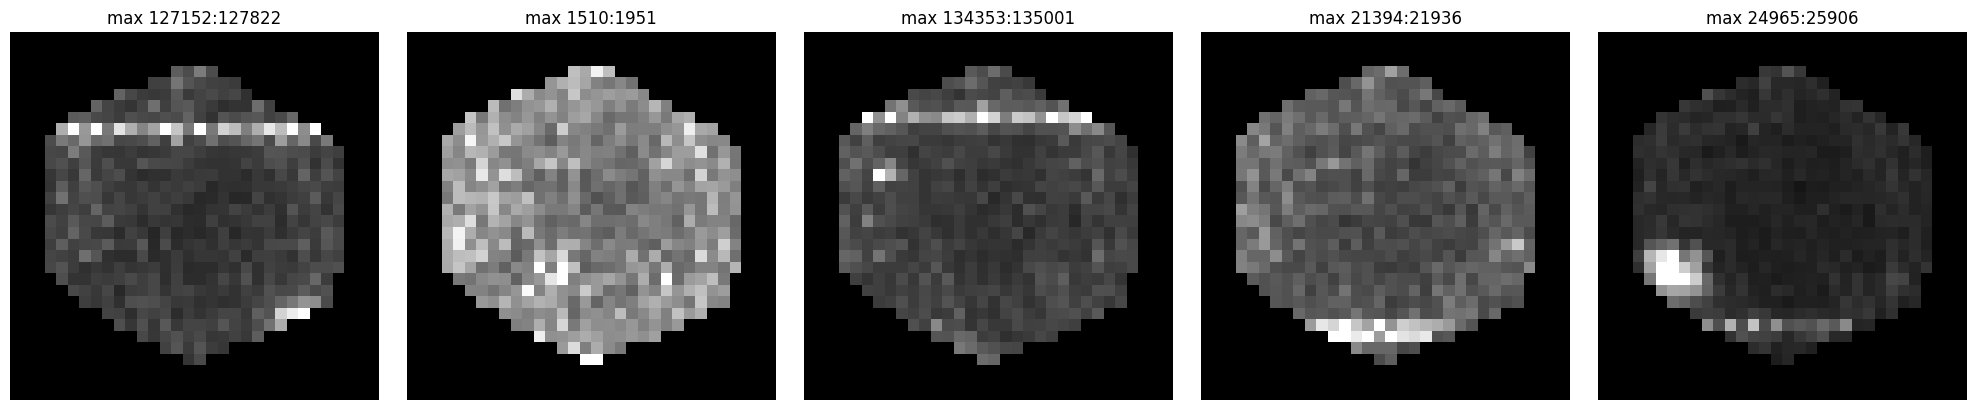

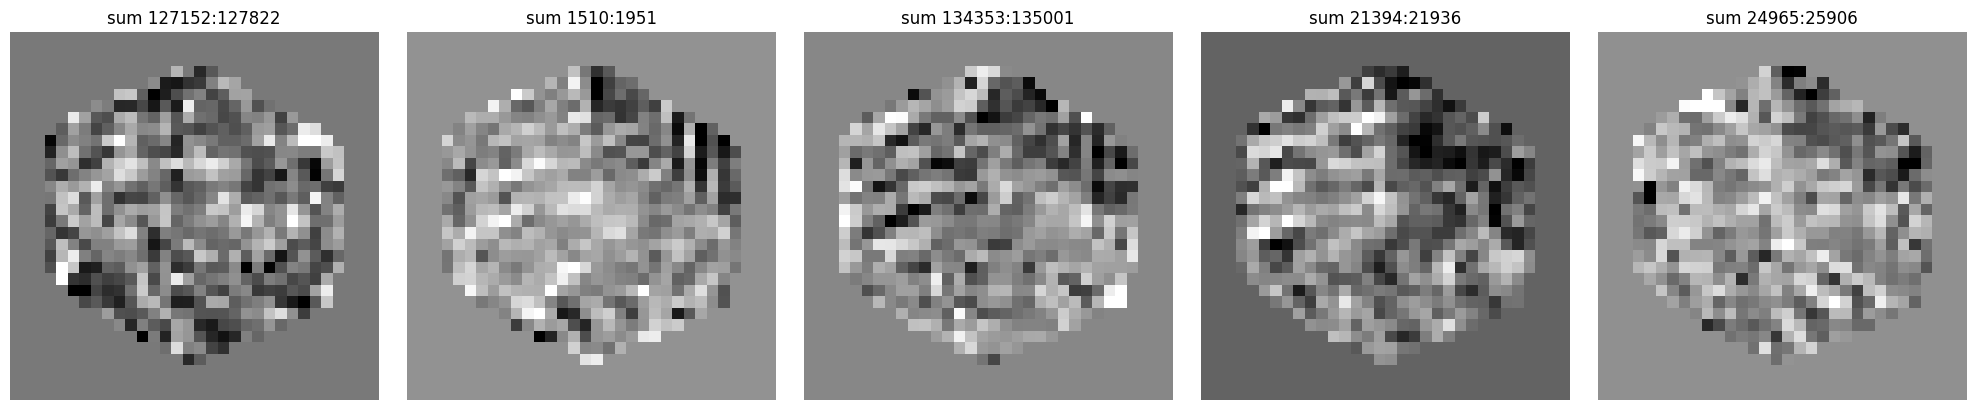

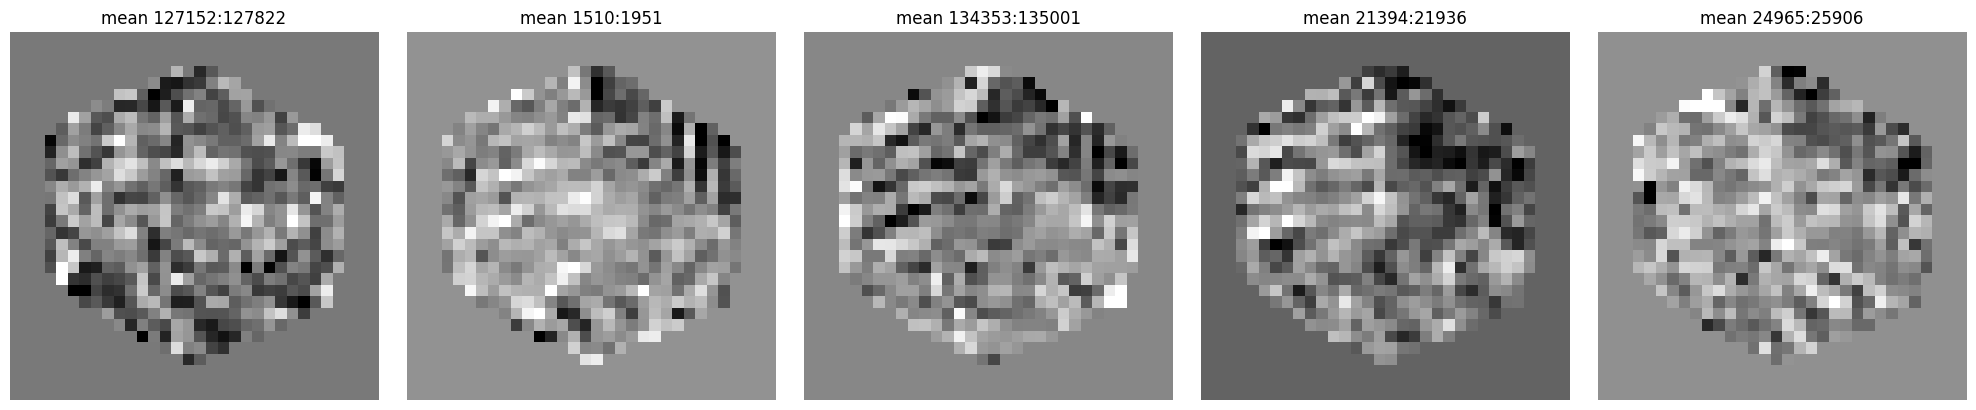

In [7]:
images_max  = slices_to_images(video, slices, reduce="max",  normalize=pct_clip_norm)
images_sum  = slices_to_images(video, slices, reduce="sum",  normalize=pct_clip_norm)
images_mean = slices_to_images(video, slices, reduce="mean", normalize=pct_clip_norm)

_ = plot_filtered_images(images_max,  [f"max {s[0]}:{s[1]}"  for s in slices]); plt.show()
_ = plot_filtered_images(images_sum,  [f"sum {s[0]}:{s[1]}"  for s in slices]); plt.show()
_ = plot_filtered_images(images_mean, [f"mean {s[0]}:{s[1]}" for s in slices]); plt.show()

# Choose which flavor to feed the model:
images = images_max


## 5. Run model on images → (N,C,H,W) probabilities

probs shape: (5, 3, 32, 32)


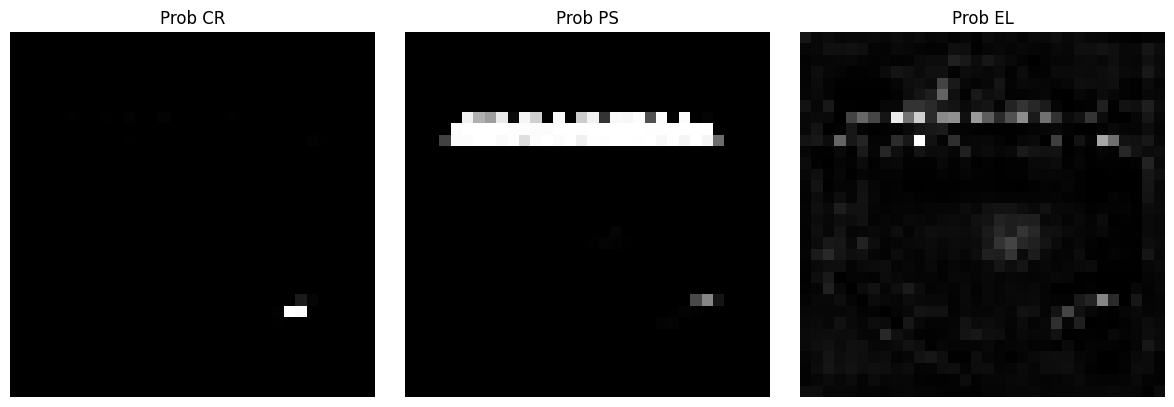

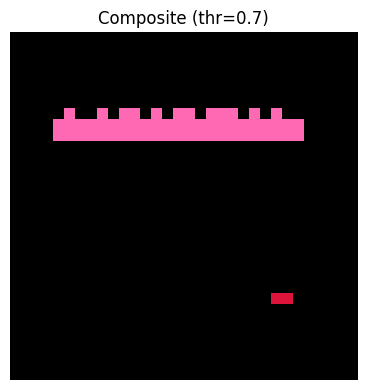

In [8]:
probs = run_model(model, DEVICE, images, batch_size=32)  # (N,3,H,W)
print("probs shape:", tuple(probs.shape))

i = 0  # pick any slice index to inspect
_ = plot_prob_maps(probs[i], class_names=("CR","PS","EL")); plt.show()
_ = plot_composite(probs[i], thr=0.7); plt.show()


## 6. Back-project one slice to detectors; overlay class scatter

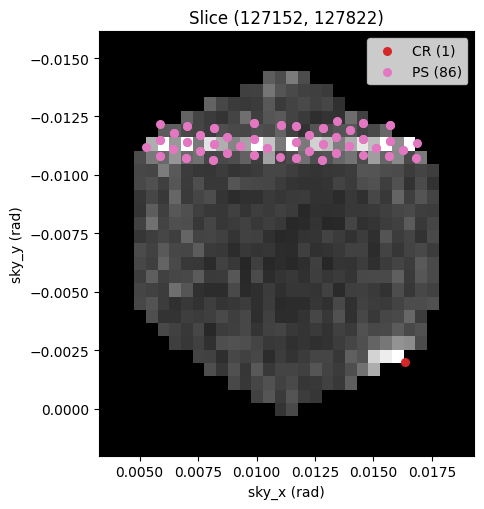

[DetHit(det_uid=22, sky_x_rad=0.007592233815064977, sky_y_rad=-0.011712573632990232, probs={'CR': 0.0014578605847878918, 'PS': 0.8306477192355943, 'EL': 0.0018203380821770001}, labels=['PS']),
 DetHit(det_uid=23, sky_x_rad=0.0075807073503216076, sky_y_rad=-0.011034743098579616, probs={'CR': 0.0019140117225112953, 'PS': 0.9856877439709201, 'EL': 0.0006064311140062651}, labels=['PS']),
 DetHit(det_uid=30, sky_x_rad=0.011686991099768188, sky_y_rad=-0.011416474606266895, probs={'CR': 0.0001000146535851815, 'PS': 0.9979090444913572, 'EL': 4.4665403726592576e-05}, labels=['PS']),
 DetHit(det_uid=31, sky_x_rad=0.012253544984505945, sky_y_rad=-0.011036174092129791, probs={'CR': 0.00011263578355608957, 'PS': 0.9946693231430351, 'EL': 6.245307322346362e-05}, labels=['PS']),
 DetHit(det_uid=54, sky_x_rad=0.007592233815064977, sky_y_rad=-0.011712573632990232, probs={'CR': 0.0014578605847878918, 'PS': 0.8306477192355943, 'EL': 0.0018203380821770001}, labels=['PS'])]

In [9]:
i = 0           # snippet index
thr = {"CR":0.5, "PS":0.5, "EL":0.5}
hits_i = preds_to_det_hits(
    fp, probs[i], det_uids=ctx.det_uids, sky_x=ctx.sky_x, sky_y=ctx.sky_y,
    thr_per_class=thr
)
_ = plot_class_scatter_hits(images[i], fp, hits_i, title=f"Slice {slices[i]}")
plt.show()


hits_i[:5]

## 7. Timestream sanity for PS/CR in slice 0

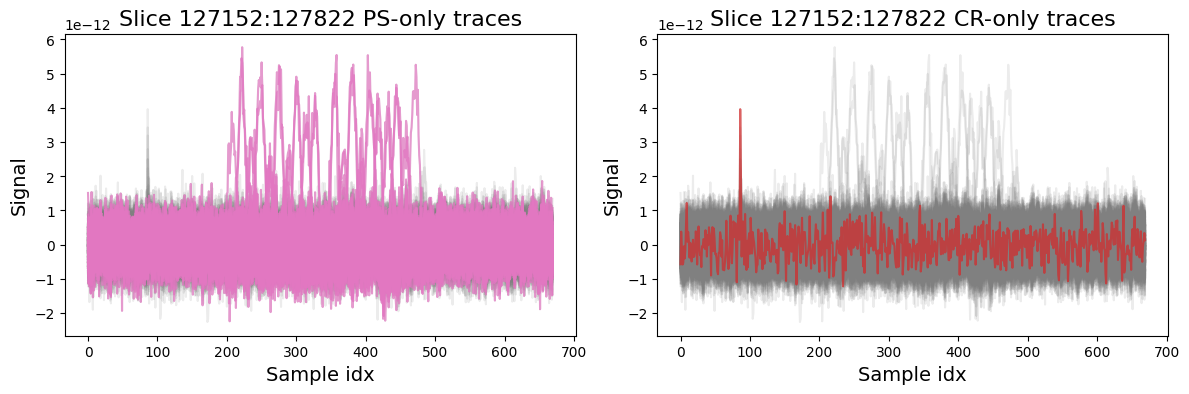

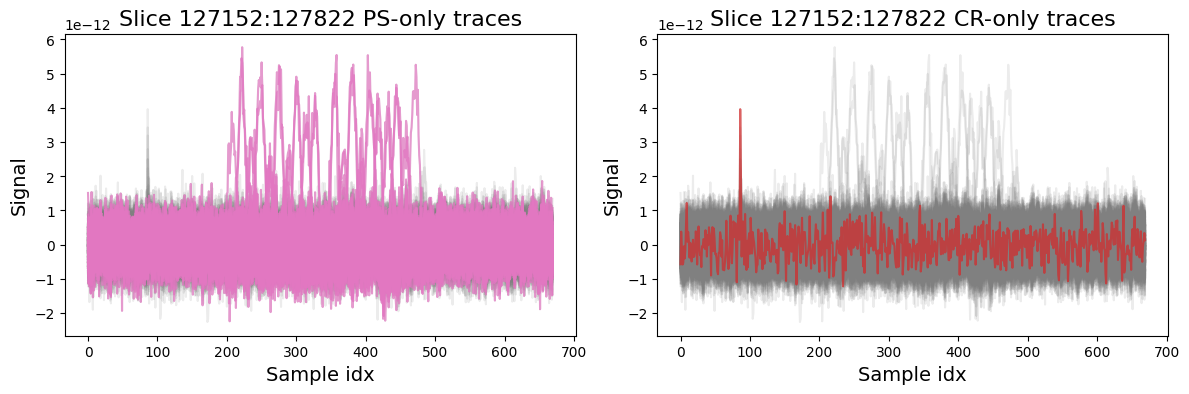

<Figure size 640x480 with 0 Axes>

In [10]:
# Build masks (boolean arrays per class) from hits
mask_ps = np.isin(ctx.det_uids, [h.det_uid for h in hits_i if "PS" in h.labels])
mask_cr = np.isin(ctx.det_uids, [h.det_uid for h in hits_i if "CR" in h.labels])
masks = {"PS": mask_ps, "CR": mask_cr}

# Get the slice boundaries
s0, s1 = slices[i]

# Ensure HPF data is ready
hp = ctx.data_hp if ctx.data_hp is not None else highpass_rows(ctx.data, ctx.s_rate_hz, fc=2.0, order=5)

# Plot timestreams
_ = plot_timestreams(hp, (s0, s1), masks)
plt.show()

#--------another option-------
det_probs0 = per_slice_det_probs(fp, probs[0])
s0, s1 = slices[0]
masks = {
    "PS": det_probs0[:, 1] >= thr["PS"],
    "CR": det_probs0[:, 0] >= thr["CR"],
    "EL": det_probs0[:, 2] >= thr["EL"],
}
hp = ctx.data_hp if ctx.data_hp is not None else highpass_rows(ctx.data, ctx.s_rate_hz, fc=2.0, order=5)
_ = plot_timestreams(hp, (s0, s1), masks); plt.show()
plt.figure()

snippet = ctx.data[:, s0:s1]



## 8. High-level wrapper: detect_on_slices → SliceResult list

In [11]:
results = detect_on_slices(ctx, fp, model, DEVICE, slices, reduce="max", normalize=pct_clip_norm,
                           hp_filter=(2.0,5), thr_per_class=thr, batch_size=32)

print("Slices processed:", len(results))
print("Example first slice: hits:", len(results[0].hits))
print("Meta:", results[0].meta)

# Convert to DataFrame for analysis
df = results_to_dataframe(results)
df.head()


Slices processed: 5
Example first slice: hits: 87
Meta: {'tod_id': '1575860019.1575871071.ar5:f090', 'release': '20230220', 'depot': '/home/yilun/shared/depots/yilun/', 'band': 'f090', 'grid_res': 32, 'hp_filter': (2.0, 5), 'reduce': 'max', 'normalize': 'pct_clip_norm', 'class_names': ['CR', 'PS', 'EL'], 'thr_per_class': {'CR': 0.5, 'PS': 0.5, 'EL': 0.5}}


,slice_from,slice_to,det_uid,sky_x_rad,sky_y_rad,prob_CR,prob_PS,prob_EL,labels
0,127152,127822,22,0.007592,-0.011713,0.001458,0.830648,0.001820,PS
1,127152,127822,23,0.007581,-0.011035,0.001914,0.985688,0.000606,PS
2,127152,127822,30,0.011687,-0.011416,0.000100,0.997909,0.000045,PS
3,127152,127822,31,0.012254,-0.011036,0.000113,0.994669,0.000062,PS
4,127152,127822,54,0.007592,-0.011713,0.001458,0.830648,0.001820,PS


### 8a. Quick queries on df

In [12]:
# Only PS above 0.7
df_ps = df[df["prob_PS"] > 0.7].sort_values(["slice_from", "prob_PS"], ascending=[True, False]).copy()
display(df_ps.head())

# Detectors hit in multiple slices
multi = df.groupby("det_uid").size().sort_values(ascending=False)
display(multi.head(10))

# Per-slice counts by label
def has_label(labels_str, label): return label in (labels_str.split(",") if isinstance(labels_str, str) else [])
df["is_PS"] = df["labels"].apply(lambda s: has_label(s, "PS"))
df["is_CR"] = df["labels"].apply(lambda s: has_label(s, "CR"))
display(df.groupby(["slice_from","slice_to"]).agg(PS=("is_PS","sum"), CR=("is_CR","sum")).reset_index())


,slice_from,slice_to,det_uid,sky_x_rad,sky_y_rad,prob_CR,prob_PS,prob_EL,labels
163,21394,21936,641,0.009462,-0.001149,0.000327,0.998290,0.000043,PS
166,21394,21936,673,0.009462,-0.001149,0.000327,0.998290,0.000043,PS
172,21394,21936,896,0.010607,-0.001066,0.000394,0.996957,0.000098,PS
175,21394,21936,928,0.010607,-0.001066,0.000394,0.996957,0.000098,PS
165,21394,21936,672,0.010041,-0.001446,0.000332,0.995417,0.000153,PS


det_uid
1759    2
672     2
641     2
1279    2
564     2
532     2
510     2
1340    2
482     2
478     2
dtype: int64

,slice_from,slice_to,PS,CR
0,21394,21936,30,0
1,24965,25906,23,24
2,127152,127822,86,1
3,134353,135001,66,4


## 9. One-liner visual tour: demo_gallery

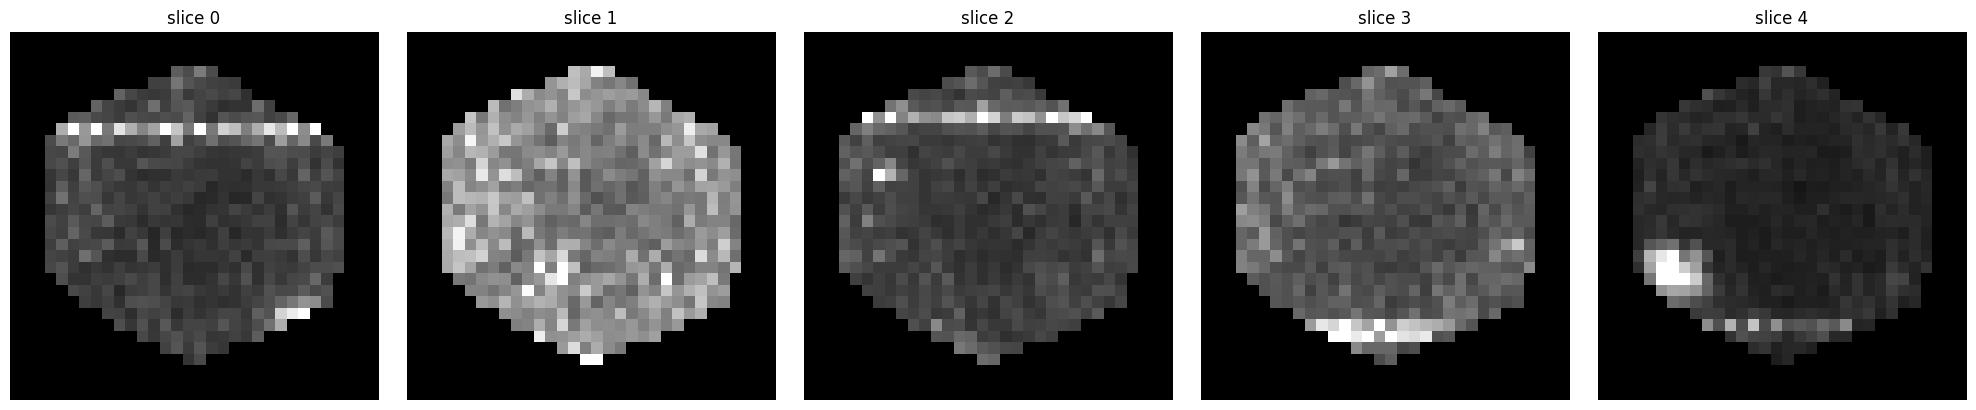

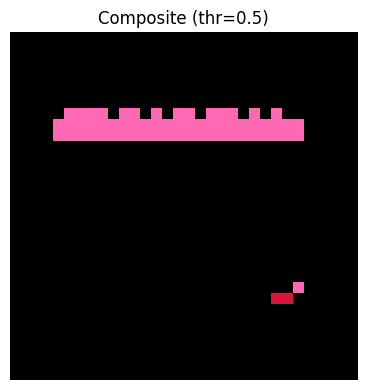

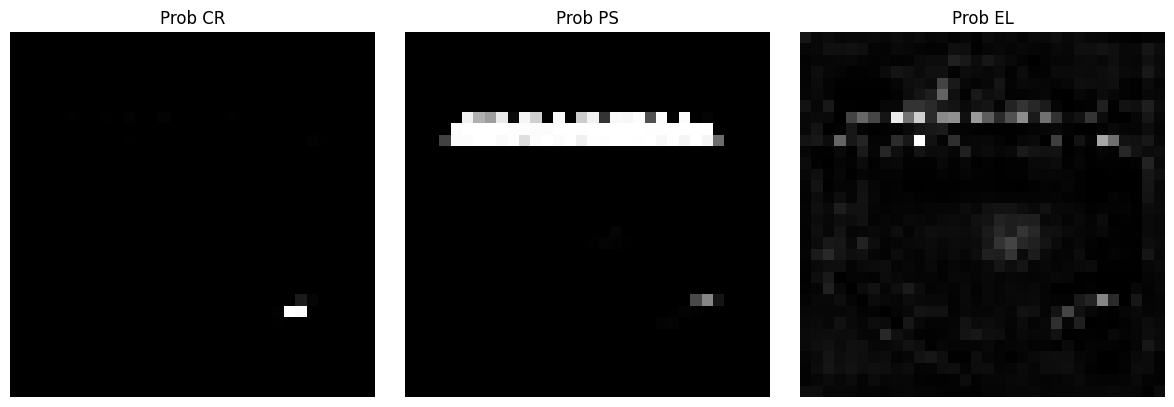

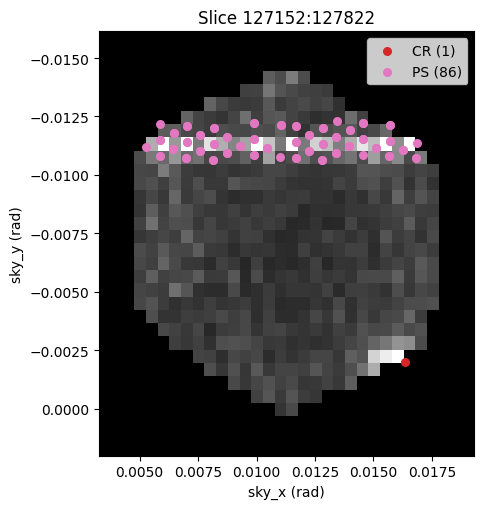

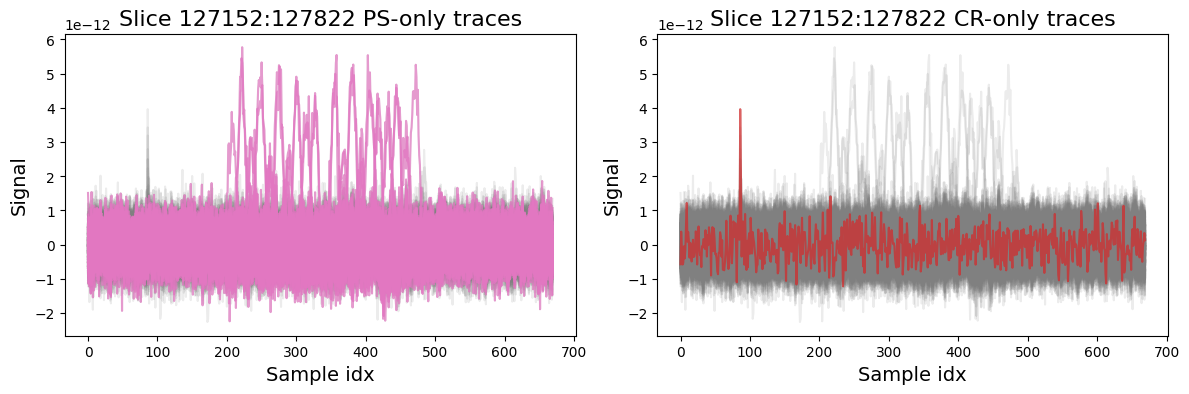

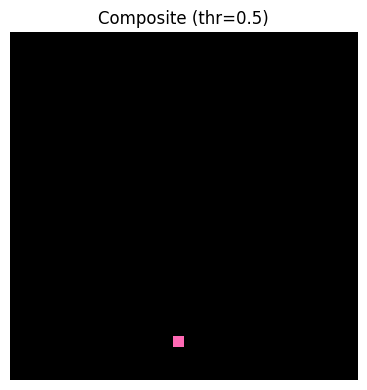

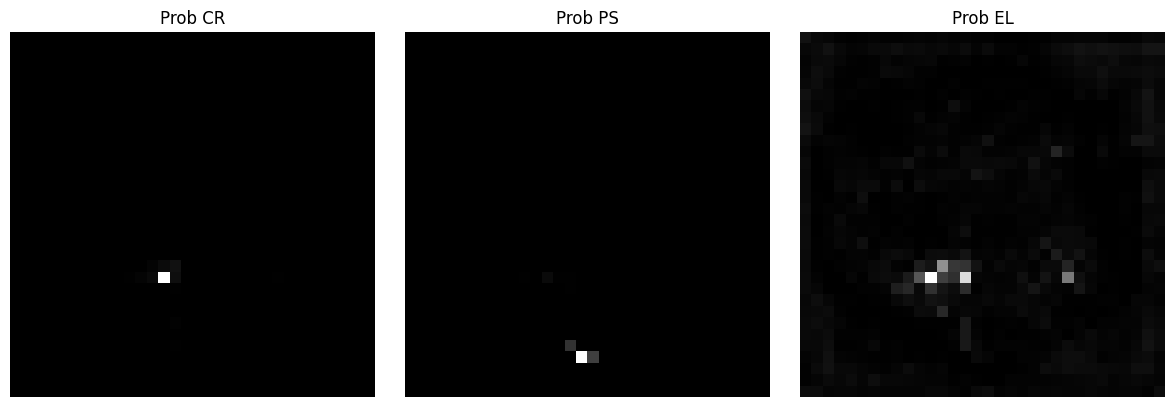

/home/theanas12/anasProjects/Tiny_U-net_pipeline/cmb_modular_pipeline.py:998: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


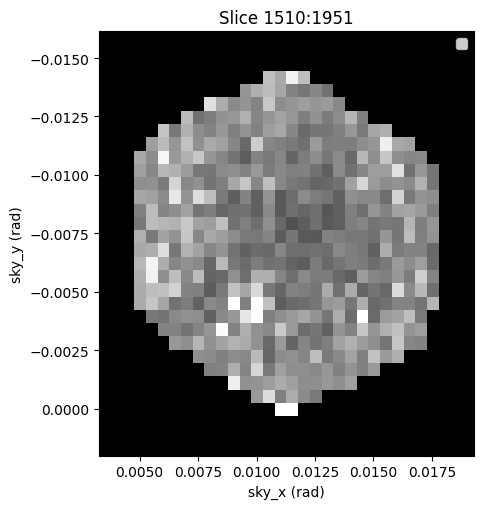

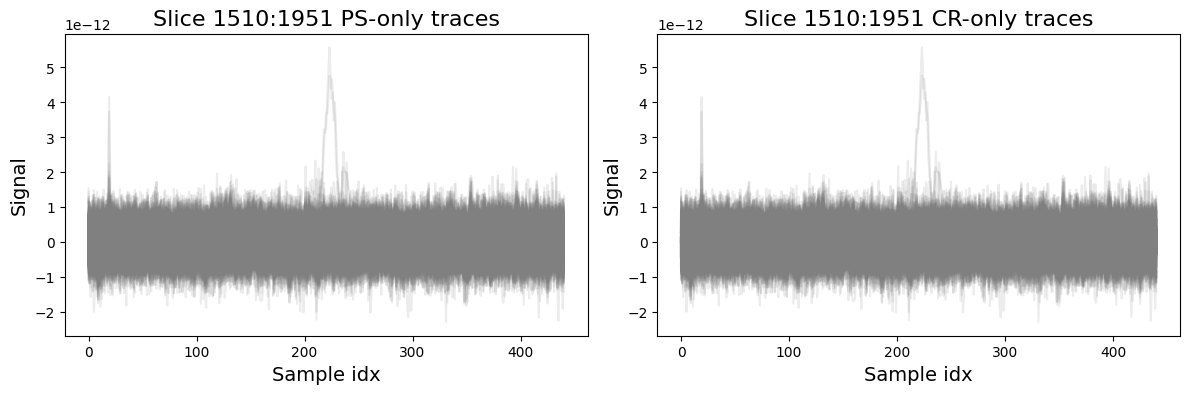

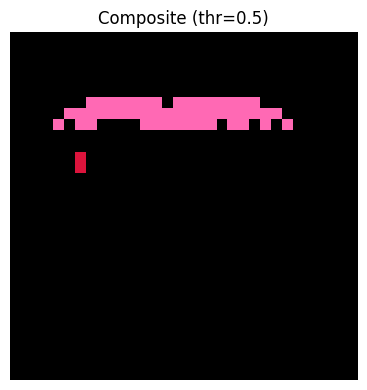

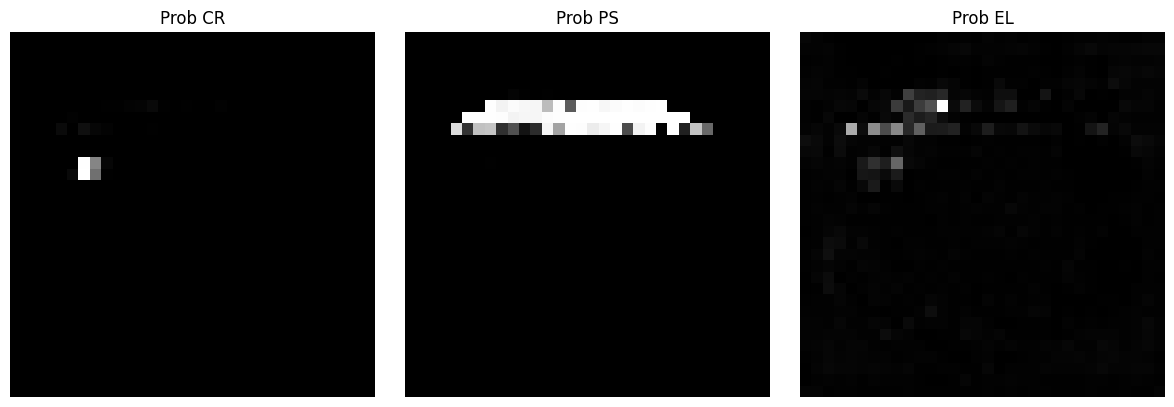

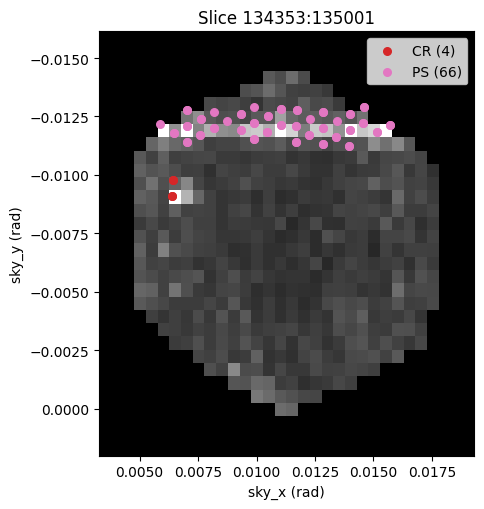

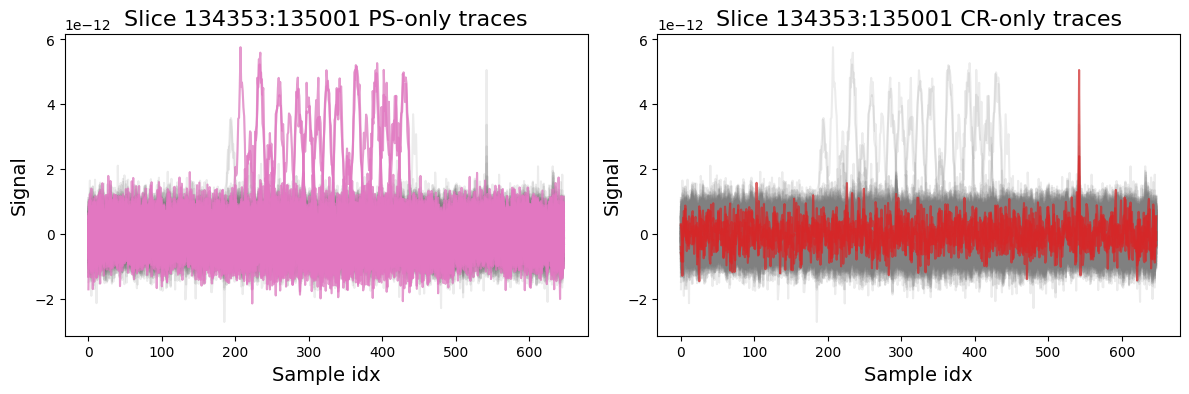

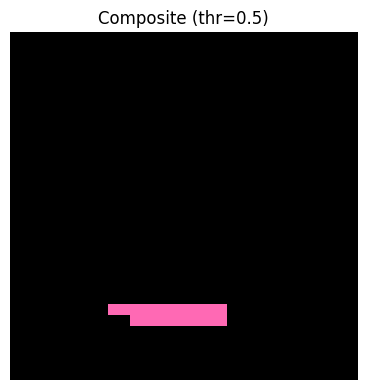

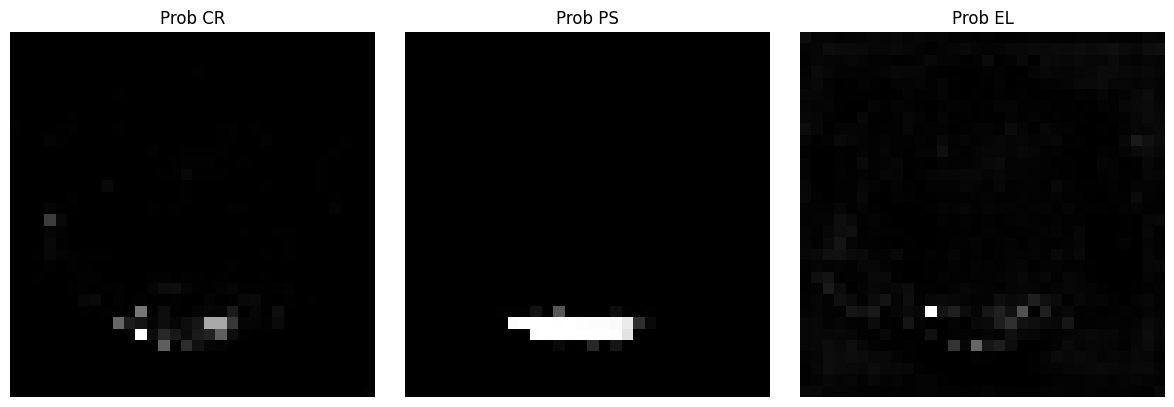

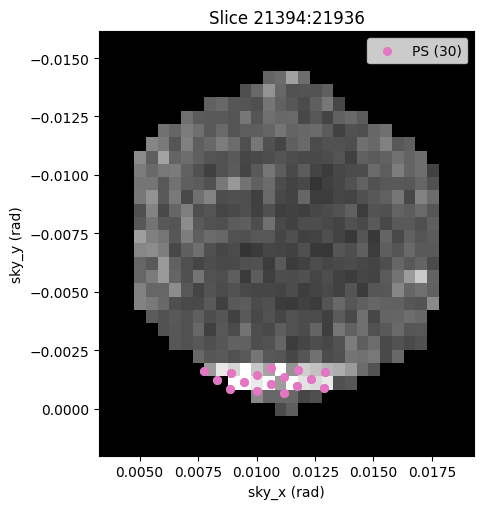

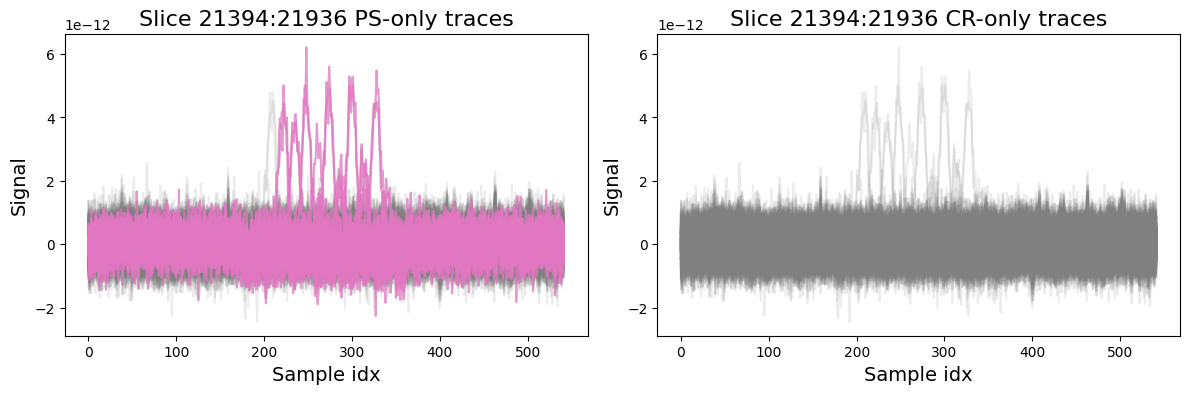

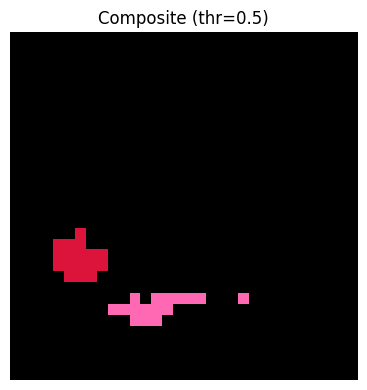

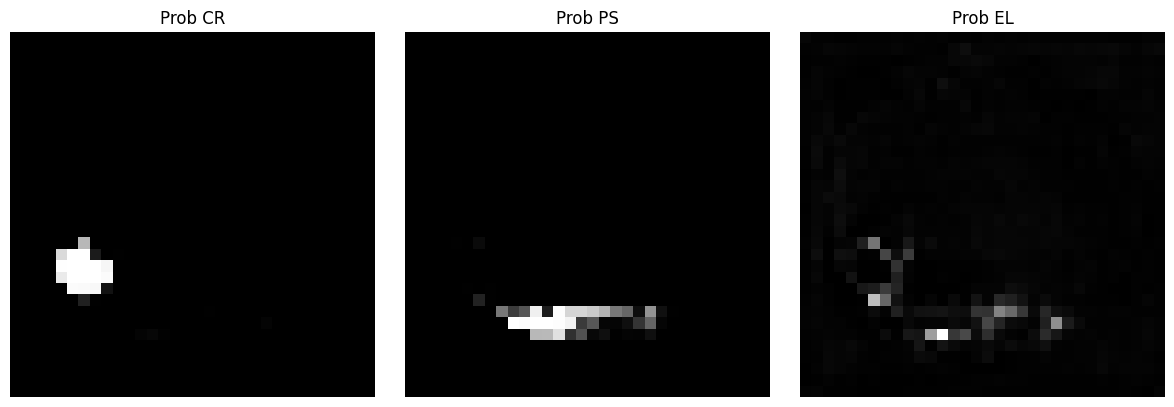

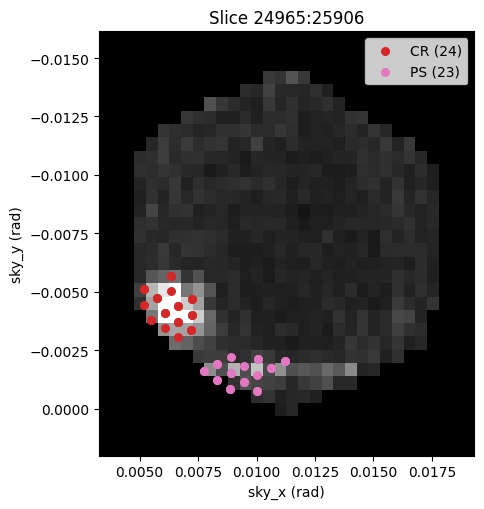

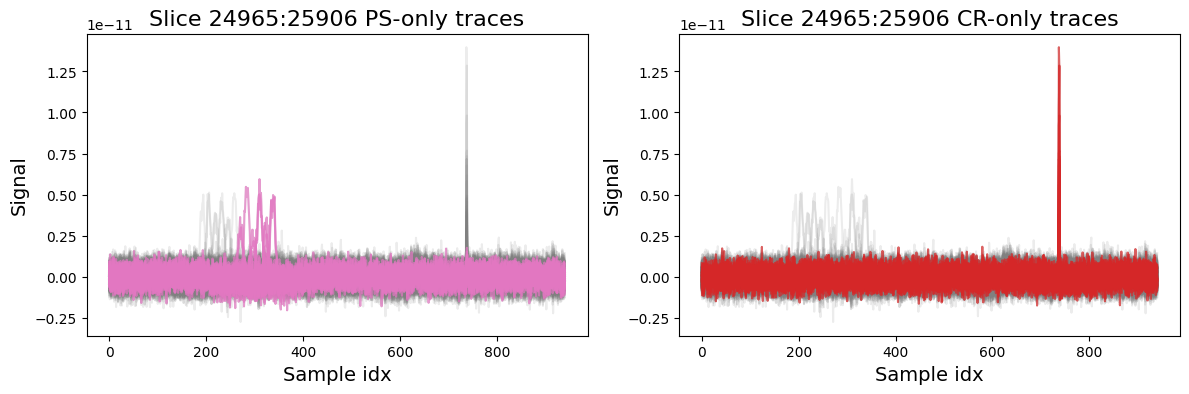

[DetHit(det_uid=22, sky_x_rad=0.007592233815064977, sky_y_rad=-0.011712573632990232, probs={'CR': 0.0014578605847878918, 'PS': 0.8306477192355943, 'EL': 0.0018203380821770001}, labels=['PS']),
 DetHit(det_uid=23, sky_x_rad=0.0075807073503216076, sky_y_rad=-0.011034743098579616, probs={'CR': 0.0019140117225112953, 'PS': 0.9856877439709201, 'EL': 0.0006064311140062651}, labels=['PS']),
 DetHit(det_uid=30, sky_x_rad=0.011686991099768188, sky_y_rad=-0.011416474606266895, probs={'CR': 0.0001000146535851815, 'PS': 0.9979090444913572, 'EL': 4.4665403726592576e-05}, labels=['PS']),
 DetHit(det_uid=31, sky_x_rad=0.012253544984505945, sky_y_rad=-0.011036174092129791, probs={'CR': 0.00011263578355608957, 'PS': 0.9946693231430351, 'EL': 6.245307322346362e-05}, labels=['PS']),
 DetHit(det_uid=54, sky_x_rad=0.007592233815064977, sky_y_rad=-0.011712573632990232, probs={'CR': 0.0014578605847878918, 'PS': 0.8306477192355943, 'EL': 0.0018203380821770001}, labels=['PS'])]

In [13]:
results_after = demo_gallery(ctx, fp, model, DEVICE, slices, thr_per_class=thr, show_filtered=True)
results_after[0].hits[:5]


## Appendix — Useful toggles

- **Normalization**: set `normalize=None` in `slices_to_images` or `detect_on_slices` to inspect raw dynamic range.
- **Reduction**: try `reduce="sum"` or `reduce="mean"` when events persist longer in a slice window.
- **Per-class thresholds**: e.g., `thr = {"CR":0.6, "PS":0.5, "EL":0.4}` to trade precision/recall per class.
- **Grid resolution**: `fp = build_fplane(ctx, grid_res=50)` for a denser image; recompute `video` after changing.
- **HPF cut**: re-run `video = tod_to_video(ctx, fp, hp_filter=(1.0,5))` and regenerate slice images; cached by `(fc, order, grid)`.
- **CSV export**: `df.to_csv("hits.csv", index=False)` for hand-off.


### Testing the model on images

In [14]:
# Load images (N, 3, 32, 32) and make grayscale like before
images = np.load('/home/theanas12/anasProjects/32images_3cls.npy', mmap_mode='r')
idxs   = [0, 1, 2]  # whatever you want to test

batch_imgs = []
for i in idxs:
    img_rgb  = images[i]              # (3,32,32)
    img_gray = img_rgb.mean(axis=0)   # (32,32)
    img_n    = pct_clip_norm(img_gray)
    batch_imgs.append(img_n.astype(np.float32))

# Model inference on raw images
probs = run_model(model, DEVICE, batch_imgs, batch_size=32)   # (N, C, 32, 32)

# Visualize one example
k = 0
plt.imshow(batch_imgs[k], cmap="gray")
plt.title("Video frame #0 (raw)")
plt.axis("off"); plt.show()
_ = plot_prob_maps(probs[k], class_names=("CR","PS","EL")); plt.show()
_ = plot_composite(probs[k], thr=0.5); plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/theanas12/anasProjects/32images_3cls.npy'